In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
class RBFLayer(layers.Layer):
    def __init__(self,num_centers,centers=None):
        super(RBFLayer, self).__init__()
        self.num_centers=num_centers
        self.centers=centers
        self.sigma=0.5

    def build(self,input_shape):
        input_dim=input_shape[-1]

        if self.centers is not None:
            self.centers=self.add_weight(
                name='centers',
                shape=(self.num_centers,input_dim),
                initializer=tf.constant_initializer(self.centers),
                trainable=True)
        else:
            self.centers = self.add_weight(
                name='centers',
                shape=(self.num_centers,input_dim),
                initializer='random_normal',
                trainable=True)

    def call(self,inputs):
        diff=tf.expand_dims(inputs,axis=1)-self.centers
        distances=tf.norm(diff,axis=-1)
        rbf=tf.exp(-distances**2)/2*self.sigma**2
        return rbf


In [3]:
data_generator=ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_generator=data_generator.flow_from_directory(
    directory='D:\SEM-6\DL-LAB\Medicinal_plants_DS',
    target_size=(256,256),
    batch_size=64,
    class_mode='categorical',
    subset='training')

val_generator=data_generator.flow_from_directory(
    directory='D:\SEM-6\DL-LAB\Medicinal_plants_DS',
    target_size=(256,256),
    batch_size=64,
    class_mode='categorical',
    subset='validation')

Found 1955 images belonging to 20 classes.
Found 479 images belonging to 20 classes.


In [4]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.03)


subsetgen=datagen.flow_from_directory(
    directory='D:\SEM-6\DL-LAB\Medicinal_plants_DS',
    target_size=(256,256),
    batch_size=64,
    class_mode='categorical',
    subset='training')

batch_size=64
input_dim=256*256
output_dim=len(train_generator.class_indices)
num_centers=10

subset_size=300
flat_images=[]    

for i in range(subset_size//subsetgen.batch_size):
    inputs,labels=subsetgen.next()
    flat_images.append(inputs.reshape(inputs.shape[0],-1))
   
flat_images=np.concatenate(flat_images,axis=0)
print(flat_images.shape)
kmeans=KMeans(n_clusters=num_centers,random_state=42,n_init=1)
kmeans.fit(flat_images)
centers=kmeans.cluster_centers_


Found 2369 images belonging to 20 classes.
(256, 196608)


In [5]:
model=models.Sequential([
    layers.Flatten(),
    RBFLayer(num_centers,centers=centers),
    layers.Dense(output_dim,activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history=model.fit(train_generator,epochs=3,validation_data=val_generator,verbose=1)

Epoch 1/3
31/31 [==============================] - 60s 2s/step - loss: 2.9948 - accuracy: 0.0675 - val_loss: 2.9931 - val_accuracy: 0.0710
Epoch 2/3
31/31 [==============================] - 49s 2s/step - loss: 2.9924 - accuracy: 0.0670 - val_loss: 2.9909 - val_accuracy: 0.0710
Epoch 3/3
31/31 [==============================] - 48s 2s/step - loss: 2.9901 - accuracy: 0.0711 - val_loss: 2.9888 - val_accuracy: 0.0710


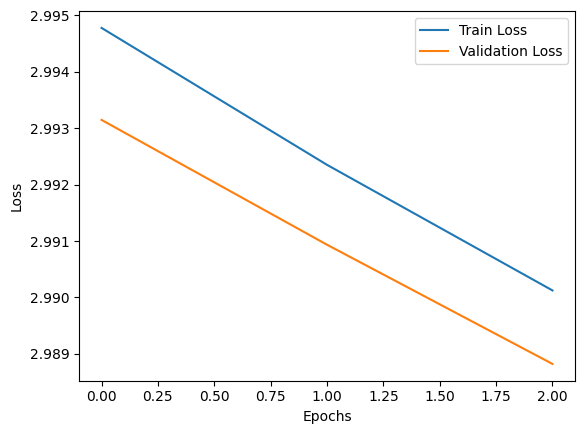

In [6]:
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
test_generator=data_generator.flow_from_directory(
    directory='D:\SEM-6\DL-LAB\Medicinal_plants_DS',
    target_size=(256,256),
    batch_size=64,
    class_mode='categorical',
    subset='validation')

loss,acc=model.evaluate(test_generator)
print("Test Accuracy:",acc)

Found 479 images belonging to 20 classes.
8/8 [==============================] - 5s 642ms/step - loss: 2.9888 - accuracy: 0.0710
Test Accuracy: 0.0709812119603157
